In [1]:
#$ Imports
import os
import sys
import json
from datetime import datetime

import random
import numpy as np
import scipy as sc
import pandas as pd
import xarray as xr
import cftime
from dask.diagnostics import ProgressBar
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import utils
from utils import settings

#$ Global variables
with open("~/s2s/paths.json") as paths_json:
    PATHS = json.load(paths_json)
with open("~/s2s/globals.json") as globals_json:
    GLOBALS = json.load(globals_json)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    print(f"Using cuda device {torch.cuda.get_device_name(0)}")

$WORK/conda-envs/s2s/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
TAU = 20

In [3]:
data_path = os.path.join(PATHS['full_globe'], 'data', f'tau_{TAU}')

In [4]:
X_darray = utils.data.load_flattened_features(data_path, 'test')
X_darray = X_darray.unstack('s')

In [5]:
y_darray = utils.data.load_flattened_targets(data_path, 'test')

In [6]:
X_darray

<xarray.DataArray 'X' (sample: 18319, lat: 25, lon: 72, var: 4)>
array([[[[ 0.05912517,  2.1069165 ,  0.02632336,  0.43548275],
         [-0.49937413,  1.72718611, -0.49306792,  0.54729575],
         [-0.44331649,  1.47658586, -1.09219305,  0.60299841],
         ...,
         [ 0.4121762 ,  1.9372867 ,  0.53344112, -0.45237225],
         [ 0.60557969,  2.27010065,  0.6591429 , -0.25992306],
         [ 0.66375295,  2.35212866,  0.52424579,  0.02881834]],

        [[ 1.07426112,  1.76890812, -0.19969462,  1.36913795],
         [ 0.73575041,  1.55191957, -0.44762098,  0.84794875],
         [ 1.11261115,  1.34344242, -0.68339704,  0.00949216],
         ...,
         [ 2.15948195,  1.36577168,  0.18664034,  0.76411589],
         [ 2.5196441 ,  1.75968428,  0.17435216,  1.2687966 ],
         [ 2.38790791,  1.90355024,  0.08968469,  1.22370146]],

        [[ 0.60900758,  0.94243972,  0.12330617,  1.1790316 ],
         [ 0.721335  ,  0.89485365,  0.16584633,  0.96439778],
         [ 1.42993269,  0.61500238,  0.0817126 ,  1.23903678],
         ...,
...
         ...,
         [ 1.85220421,  0.16065869,  1.11100808,  0.55903667],
         [ 1.21828278,  0.11660398,  1.22617753,  1.06840294],
         [        nan,  0.13063465,  0.96655656,         nan]],

        [[ 0.59681529,  1.04160523,  1.17180249,  0.40286303],
         [ 0.33276449,  1.21867379,  0.97006843,  0.83519942],
         [        nan,  0.85224258,  0.93286009,         nan],
         ...,
         [ 1.10509773,  0.64731076,  0.7428043 ,  2.18174838],
         [        nan,  0.81310784,  0.9890496 ,         nan],
         [        nan,  0.80819405,  1.21329546,         nan]],

        [[ 0.95479564,  0.92384328,  0.28468333, -0.18406593],
         [        nan,  0.79743859,  0.56224579,         nan],
         [        nan,  0.53441306,  0.77100453,         nan],
         ...,
         [-0.26890124,  0.30918072,  0.43158997,  0.53229779],
         [-0.14821445,  0.41379191,  0.44924952,  1.06931865],
         [-0.01024603,  0.63714738,  0.39020706,  1.42676393]]]])
Coordinates:
  * lat        (lat) int64 -60 -55 -50 -45 -40 -35 -30 ... 30 35 40 45 50 55 60
  * lon        (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * var        (var) object 'SST' 'UBOT' 'VBOT' 'zos'
  * member_id  (sample) int64 8 8 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8 8 8
  * time       (sample) object '1850-01-06 00:00:00' ... '2100-12-12 00:00:00'
  * sample     (sample) object MultiIndex

In [10]:
variables = ['zos', 'SST', 'UBOT', 'VBOT']

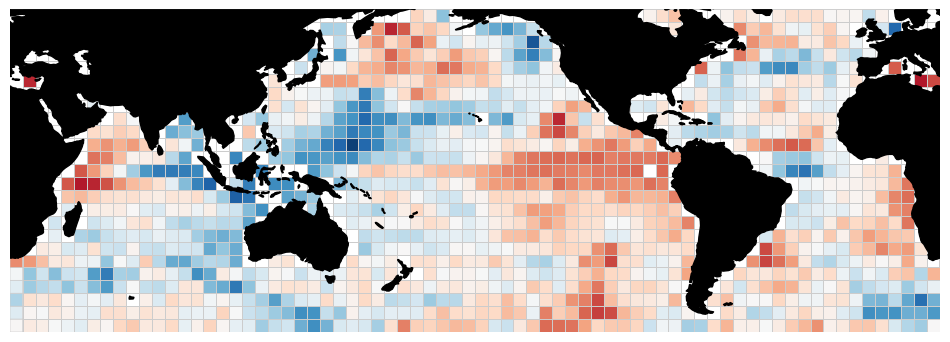

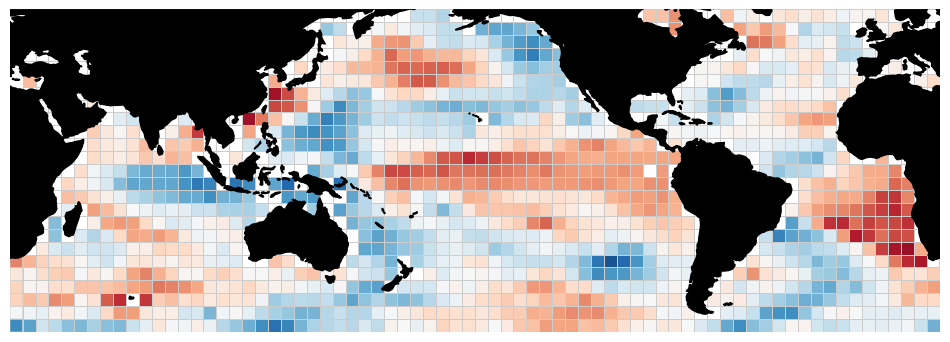

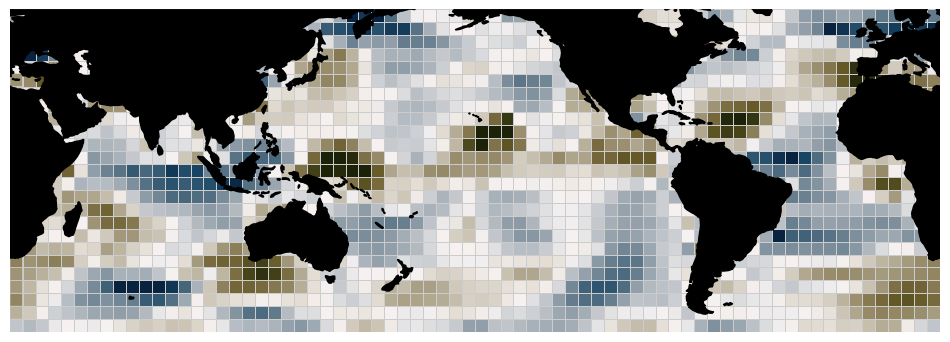

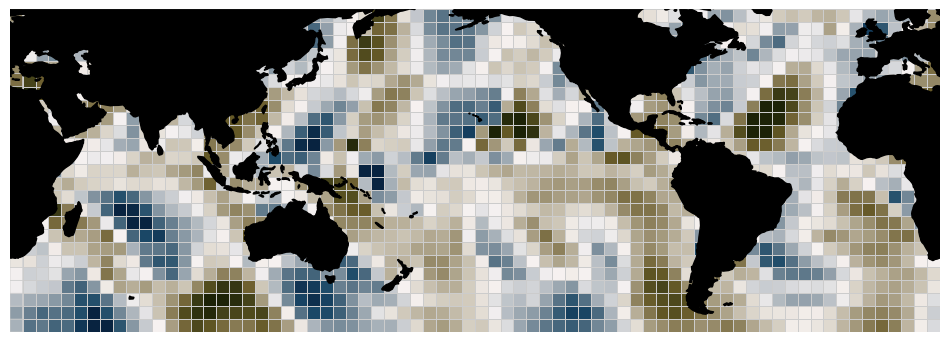

In [14]:
itime = 1600

for var in variables:
    fig, ax = plt.subplots(
        figsize=(12,6),
        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=202.6)}
    )

    cmap = plt.get_cmap('RdBu_r') if var in ['SST', 'zos'] else cmo.cm.diff
    X_darray.sel(var=var).isel(sample=itime).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=-3, vmax=3,
        edgecolor=(0.8,0.8,0.8), linewidth=0.5,
        add_colorbar=False
    )
    ax.set_title('')
    ax.add_feature(cartopy.feature.LAND, color='k', zorder=3)
    ax.axis('off')
    plt.savefig(f'input_{var}.pdf', dpi=300, bbox_inches='tight')

## Target fields


================== TARGET ==================


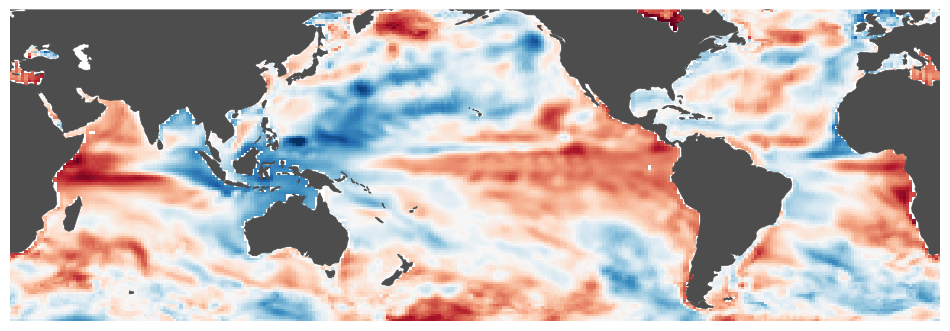

In [25]:
print('\n================== TARGET ==================')

fig, ax = plt.subplots(
    figsize=(12,6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=202.6)}
)

y_darray.isel(sample=itime).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=plt.get_cmap('RdBu_r'),
    vmin=-3, vmax=3,
    add_colorbar=False
)
ax.set_title('')
ax.add_feature(cartopy.feature.LAND, color=(0.3,0.3,0.3), zorder=3)
ax.axis('off')
plt.savefig(f'target.pdf', dpi=300, bbox_inches='tight')

## Predictions

In [11]:
pred_mean = xr.open_dataarray(os.path.join(PATHS['s2s_predictions'], f'tau_{TAU}', 'pred_mean.nc'))
pred_logvar = xr.open_dataarray(os.path.join(PATHS['s2s_predictions'], f'tau_{TAU}', 'pred_logvar.nc'))

residual_standardizer = xr.open_dataset(
    os.path.join(PATHS['s2s_predictions'], f'tau_{TAU}', 'residual_standardizer.nc')
)

pred_std = np.sqrt(np.exp(pred_logvar))
pred_std = pred_std * residual_standardizer['std']

In [28]:
pred_loc = pred_mean.sel(lat=14, lon=145, method='nearest')
lat = pred_loc['lat'].item()
lon = pred_loc['lon'].item()

In [29]:
dlat = (pred_mean['lat'][1:].values - pred_mean['lat'][:-1].values).mean()
dlon = (pred_mean['lon'][1:].values - pred_mean['lon'][:-1].values).mean()

In [30]:
plt.style.use('bmh')


================== PRED MEAN ==================


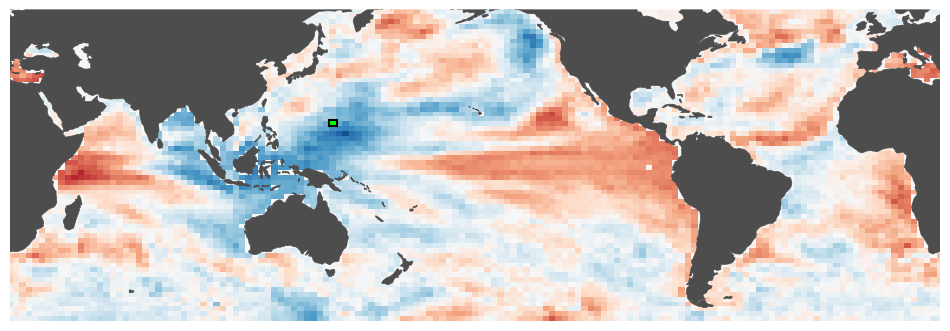

In [31]:
print('\n================== PRED MEAN ==================')

fig, ax = plt.subplots(
    figsize=(12,6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=202.6)}
)

pred_mean.isel(time=itime).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=plt.get_cmap('RdBu_r'),
    vmin=-3, vmax=3,
    add_colorbar=False
)

# Add patch
rect = mpl.patches.Rectangle(
    (lon+dlon/2, lat+dlat/2), width=1.2*dlon, height=1.2*dlat, transform=ccrs.PlateCarree(), 
    edgecolor='k', lw=1.5, facecolor='lime'
)
ax.add_patch(rect)

ax.set_title('')
ax.add_feature(cartopy.feature.LAND, color=(0.3,0.3,0.3), zorder=3)
ax.axis('off')
plt.savefig(f'pred_mean.pdf', dpi=300, bbox_inches='tight')


================== PRED STD ==================


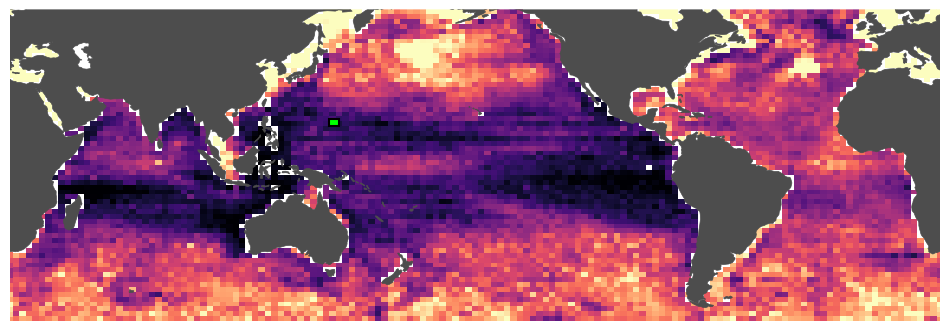

In [32]:
print('\n================== PRED STD ==================')

fig, ax = plt.subplots(
    figsize=(12,6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=202.6)}
)

pred_std.isel(time=itime).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=plt.get_cmap('magma'),
    vmin=0.2, vmax=0.8,
    add_colorbar=False
)

# Add patch
rect = mpl.patches.Rectangle(
    (lon+dlon/2, lat+dlat/2), width=1.5*dlon, height=1.5*dlat, transform=ccrs.PlateCarree(), 
    edgecolor='k', lw=1.5, facecolor='lime'
)
ax.add_patch(rect)

ax.set_title('')
ax.add_feature(cartopy.feature.LAND, color=(0.3,0.3,0.3), zorder=3)
ax.axis('off')
plt.savefig(f'pred_std.pdf', dpi=300, bbox_inches='tight')


================== PRED STD ==================


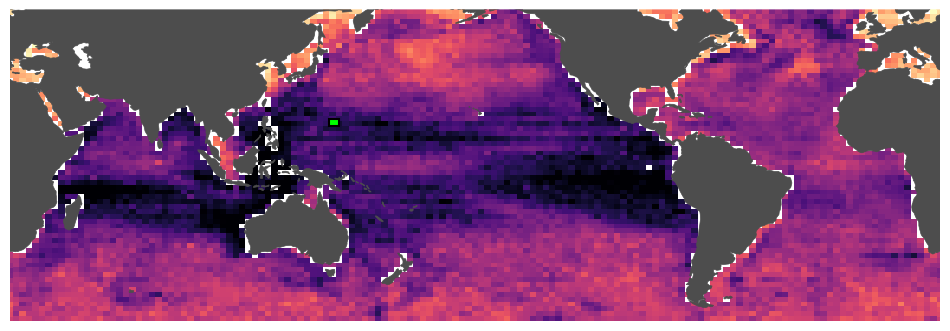

In [33]:
print('\n================== PRED STD ==================')

fig, ax = plt.subplots(
    figsize=(12,6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=202.6)}
)

np.log(pred_std**2).isel(time=itime).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=plt.get_cmap('magma'),
    vmin=-3, vmax=1,
    add_colorbar=False
)

# Add patch
rect = mpl.patches.Rectangle(
    (lon+dlon/2, lat+dlat/2), width=1.5*dlon, height=1.5*dlat, transform=ccrs.PlateCarree(), 
    edgecolor='k', lw=1.5, facecolor='lime'
)
ax.add_patch(rect)

ax.set_title('')
ax.add_feature(cartopy.feature.LAND, color=(0.3,0.3,0.3), zorder=3)
ax.axis('off')
plt.savefig(f'pred_logvar.pdf', dpi=300, bbox_inches='tight')